# Exploratory Data Analysis: Lichess database

This jupyter notebook contains an exploratory data analysis done over a chess database with information from 200k games. Each game (the rows of the data frame) contains categorical variates, such as the type of opening, and numerical variates, such as the elo of each player.

(Tentative) The main objective of this EDA was to determine regularities in the playstyle and how these changed when variates, such as elo, changed. Furthermore, the analysis includes general statistics calculations including location, scale, and shape parameters (mean value, variance, skewness, and kurtosis) which helped draw conclusions from a set of hypothesis tests.

### Remarks

1. In general, the notebook has the following structure: 

2. Each code cell includes hashed text explaining briefly what the code is supposed to be doing. Additional commentary is contained in the markdown cells.

3. All the required libraries are included in the first code cell, namely the preamble of the notebook. Exceptions include particular ```scipy``` submodules used for miscellaneous statistics calculations.

4. Recurrent code is included in the ```functions.py``` module.

5. All the pertinent references are in the ```README.md``` file.

6. **All the graphs** contained in this notebook are saved in the ```graphs``` directory.

### Hypothesis Tests

#### A/B

#### ANOVA

In [ ]:
#Preamble
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import functions as f

In [3]:
#reading database
games_df = pd.read_csv('games.csv')

/tmp/ipykernel_46989/2263780526.py:2: DtypeWarning: Columns (19,20,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,243,244,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620) have mixed types. Specify dtype option on import or set low_memory=False.
  games_df = pd.read_csv('games.csv')


In [4]:
rank = []
avg_elo = (games_df['WhiteElo'] + games_df['BlackElo'])/2
for elo in avg_elo:
    if elo >= 2000:
        rank.append('Very High Elo')
    elif elo >= 1800:
        rank.append('High Elo')
    elif elo >= 1400:
        rank.append('Mid Elo')
    else:
        rank.append('Low Elo')

rank = np.asarray(rank)

games_df['Elo Tier'] = rank

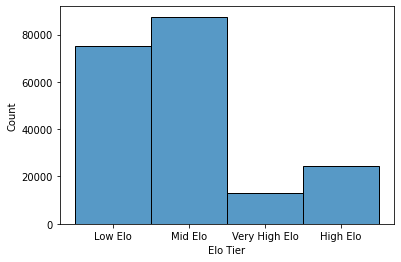

In [7]:
elo_tier_histplot = sns.histplot(games_df, x = 'Elo Tier')
fig = elo_tier_histplot.get_figure()
fig.savefig('graphs/elo_tier_histplot.pdf')